In [25]:
# select the data
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from colmap.scripts.python.read_model import read_model, qvec2rotmat
from colmap.scripts.python.read_dense import read_array
from imageio import imread
import matplotlib.pyplot as plt
import deepdish as dd
import h5py
import matplotlib.patches as patches
from time import time

# root = '/cvlabdata1/cvlab/datasets_eduard/colmap/'
root = '/cvlabdata1/cvlab/datasets_eduard/colmap_pa/'

seq = 'reichstag'
src = root + '/' + seq
print(f'Done')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


In [26]:
# load reconstruction from colmap
cameras, images, points = read_model(path=src + '/dense/sparse', ext='.bin')

print(f'Cameras: {len(cameras)}')
print(f'Images: {len(images)}')
print(f'3D points: {len(points)}')

Cameras: 75
Images: 75
3D points: 17823


In [27]:
# they are all dictionaries
# keys are entries which are not necessarily 0-indexed
indices = [i for i in cameras]

idx0 = indices[0]

# this contains some camera information (intrinsics)
print(cameras[idx0])

# this contains the file name (images are already rectified), extrinsics,
# indices to 3d points ("point3D_ids") and 2d projections ("xys")
print(images[idx0])

# this contains the 3d points for the entire reconstructed model
print(points[1])

Camera(id=75, model='PINHOLE', width=817, height=606, params=array([871.02185059, 871.02185059, 408.5       , 303.        ]))
Image(id=75, qvec=array([ 9.99827681e-01, -8.32007327e-04,  1.83246056e-02, -2.85046911e-03]), tvec=array([-0.51743224, -0.06479301,  0.26567356]), camera_id=75, name='92753909_16247242.jpg', xys=array([[ 7.08133478e+02,  1.47324081e+02],
       [ 1.02678580e+02,  1.53333860e+02],
       [ 7.03314068e+02,  1.58797962e+02],
       ...,
       [ 4.95440645e+01,  3.81322933e-01],
       [ 1.26119561e+02,  2.46658801e+01],
       [ 9.68083477e+01, -4.58368982e+00]]), point3D_ids=array([-1, -1, -1, ..., -1, -1, -1]))
Point3D(id=1, xyz=array([ 4.38409733, -1.10574277, 10.1773167 ]), rgb=array([42, 48, 51]), error=array(0.70489608), image_ids=array([73, 68, 13, 42, 50, 22]), point2D_idxs=array([146,  17, 129,  58,  31,  87]))


Number of points: 1669


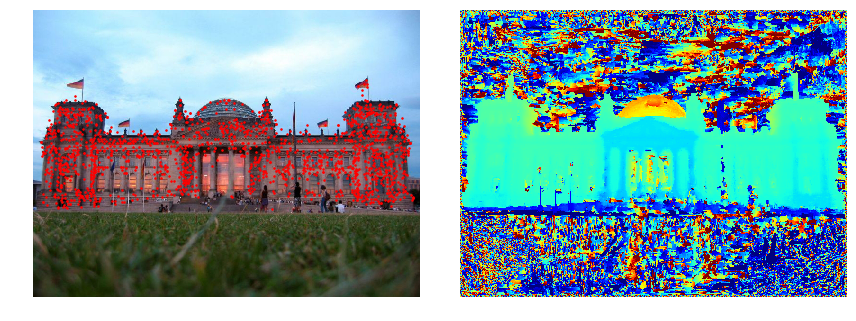

In [29]:
# so e.g. to get an image and the 2d points on it...
def get_image(idx):
    im = imread(src + '/dense/images/' + images[idx].name)
    depth = read_array(src + '/dense/stereo/depth_maps/' + images[idx].name + '.photometric.bin')
    min_depth, max_depth = np.percentile(depth, [5, 95])
    depth[depth < min_depth] = min_depth
    depth[depth > max_depth] = max_depth

    # reformat data
    q = images[idx].qvec
    R = qvec2rotmat(q)
    T = images[idx].tvec
    p = images[idx].xys
    pars = cameras[idx].params
    K = np.array([[pars[0], 0, pars[2]], [0, pars[1], pars[3]], [0, 0, 1]])
    pids = images[idx].point3D_ids
    v = pids >= 0
    print('Number of points: {}'.format((pids > -1).sum()))

    return {
        'image': im,
        'depth': depth,
        'K': K,
        'q': q,
        'R': R,
        'T': T,
        'xys': p,
        'ids': pids,
        'valid': v}

idx = indices[0]
data = get_image(idx)

# plot the image and the points that match to the 3D model
ms = 3
fig = plt.figure(figsize=(12, 12))
fig.add_subplot(1, 2, 1)
f1 = plt.imshow(data['image'])
plt.plot(data['xys'][data['valid'], 0], data['xys'][data['valid'], 1], 'r.', markersize=ms)
plt.axis('off')

# plot the depth map
fig.add_subplot(1, 2, 2)
f2 = plt.imshow(data['depth'])
f2.set_cmap('jet')
plt.axis('off')
fig.tight_layout()
plt.show()

(-0.5, 816.5, 605.5, -0.5)

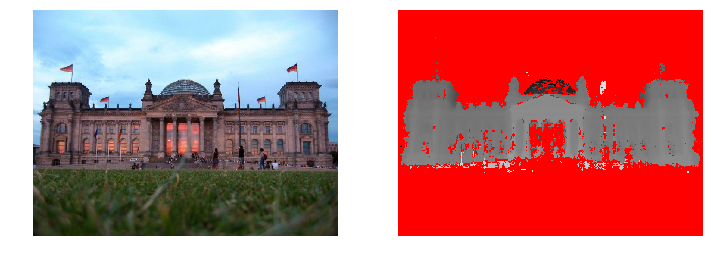

In [31]:
# these depth maps are "dirty"
# we cleaned them up a little bit, they can be found here
im = imread(src + '/dense/images/' + images[idx].name)
base = '.'.join(images[idx].name.split('.')[:-1])
with h5py.File(src + '/dense/stereo/depth_maps_clean_300_th_0.10/' + base + '.h5', 'r') as f:
    depth = f['depth'].value

fig = plt.figure(figsize=(12, 12))

f1 = fig.add_subplot(1, 2, 1)
plt.imshow(im)
plt.axis('off')
    
f2 = fig.add_subplot(1, 2, 2)
occ = depth == 0
rgb = depth.copy()
rgb[depth > 0] = (rgb[depth > 0].max() - rgb[depth > 0]) / (rgb[depth > 0].max() - rgb[depth > 0].min())
rgb = rgb[None, ...].repeat(3, axis=0)
rgb[0][occ] = 1
rgb[1][occ] = 0
rgb[2][occ] = 0
plt.imshow(rgb.transpose((1, 2, 0)).astype(np.float))
plt.axis('off')
    
# the procedure to generate them is on the other scripts

In [32]:
# i don't like their data structure so i can just retrieve all 3d points
xyz, rgb = [], []
for i in points:
    xyz.append(points[i].xyz)
    rgb.append(points[i].rgb)
xyz = np.array(xyz)
rgb = np.array(rgb)

# you can also retrieve the points that can be found for this image only
cur = []
subset = []
for p in data['ids']:
    if p >= 0:
        cur.append(points[p].xyz)
        subset.append(p)
cur = np.array(cur)

print(xyz.shape)
print(cur.shape)

(17823, 3)
(1669, 3)


In [33]:
# you can use this to plot it but it's very heavy
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
scatter = dict(
    mode="markers",
    name="Full",
    type="scatter3d",    
    x=x,
    y=y,
    z=z,
    marker = dict(size=1, color="rgb(0, 0, 255)"),
)

x2, y2, z2 = cur[:, 0], cur[:, 1], cur[:, 2]
scatter2 = dict(
    mode="markers",
    name="Image",
    type="scatter3d",    
    x=x2,
    y=y2,
    z=z2,
    marker = dict(size=2, color="rgb(255, 0, 0)"),
)

rg = [
        [min((x.min(), x2.min())), max((x.max(), x2.max()))],
        [min((y.min(), y2.min())), max((y.max(), y2.max()))],
        [min((z.min(), z2.min())), max((z.max(), z2.max()))],
     ]

layout = dict(
    title = 'Point cloud',
    scene = dict(
        xaxis = dict(zeroline=False, range=rg[0]),
        yaxis = dict(zeroline=False, range=rg[1]),
        zaxis = dict(zeroline=False, range=rg[2]),
    )
)

# this is for all points (red) and image points (blue)
# fig = dict( data=[scatter2, scatter], layout=layout )

# this only for the latter
fig = dict( data=[scatter2], layout=layout )

iplot(fig, filename='3d point clustering')
print('Done')

Done


(3, 1669)
0
0
0
0


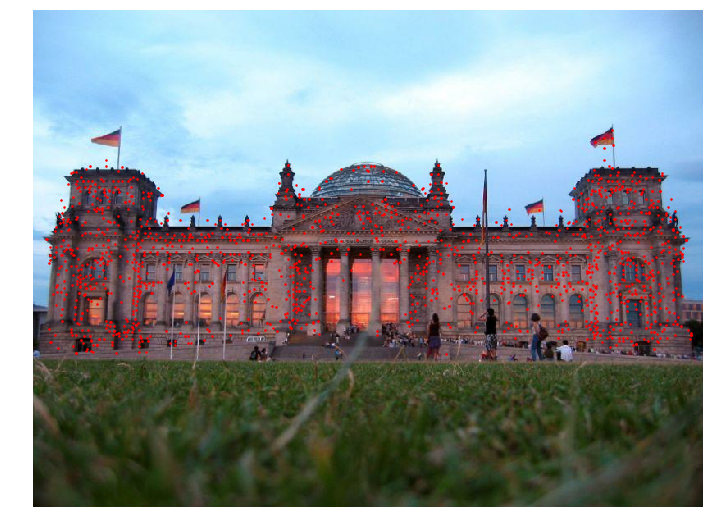

In [34]:
# you can also use the intrinsics/extrinsics 
# to project the points on the camera plane
# which should look very similar to the image above
depth = data['depth']
K = data['K']
R = data['R']
T = data['T']

p_proj = np.dot(K, np.dot(R, cur.T) + T[..., None])
p_proj = p_proj / p_proj[2, :]

fig = plt.figure(figsize=(12, 12))
f = plt.imshow(data['image'])
plt.plot(p_proj[0, :], p_proj[1, :], 'r.', markersize=3)
plt.axis('off')

# check that all points are inside
print(p_proj.shape)
print((p_proj[0, :] < 0).sum())
print((p_proj[0, :] > data['image'].shape[1]).sum())
print((p_proj[1, :] < 0).sum())
print((p_proj[1, :] > data['image'].shape[0]).sum())

Number of points: 1931
Number of points: 1737
In common: 161


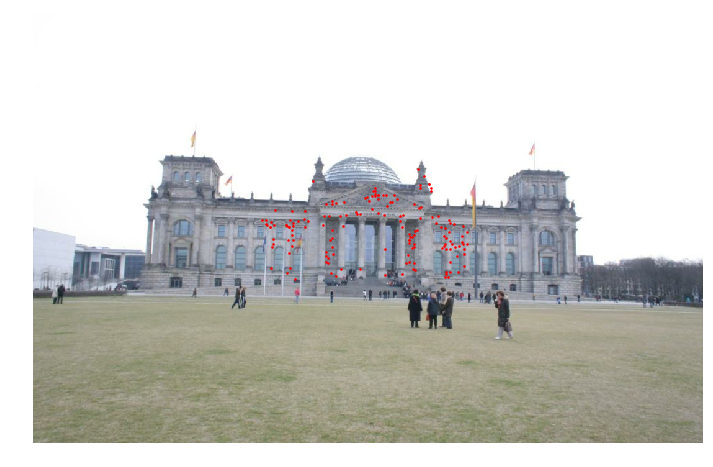

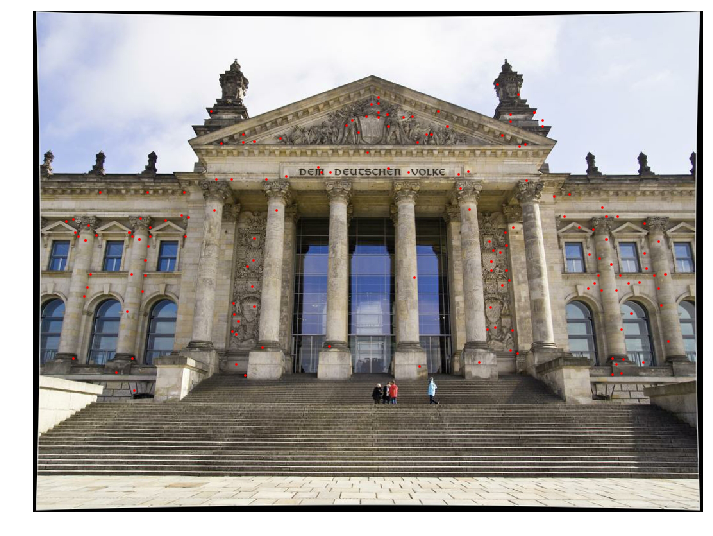

In [35]:
# now we can read two images
idx1, idx2 = 10, 30
data1 = get_image(indices[idx1])
data2 = get_image(indices[idx2])

# find the points in common
v1 = data1['ids'][data1['ids'] > 0]
v2 = data2['ids'][data2['ids'] > 0]
common = np.intersect1d(v1, v2)
print(f'In common: {len(common)}')
cur = []
for p in common:
    cur.append(points[p].xyz)
cur = np.array(cur)

# for compatibility
cur1, cur2 = cur, cur

# project them separately onto each image
depth1 = data1['depth']
K1 = data1['K']
R1 = data1['R']
T1 = data1['T']
p_proj1 = np.dot(K1, np.dot(R1, cur1.T) + T1[..., None])
p_proj1 = p_proj1 / p_proj1[2, :]

depth2 = data2['depth']
K2 = data2['K']
R2 = data2['R']
T2 = data2['T']
p_proj2 = np.dot(K2, np.dot(R2, cur2.T) + T2[..., None])
p_proj2 = p_proj2 / p_proj2[2, :]

# eliminate weird points
inv = np.bitwise_and(
    np.bitwise_and(p_proj1[0, :] >= 0, p_proj1[0, :] < data1['image'].shape[1]),
    np.bitwise_and(p_proj1[1, :] >= 0, p_proj1[1, :] < data1['image'].shape[0])
)
# print(inv)
# print(inv.sum())
p_proj1 = p_proj1[:, inv]

inv = np.bitwise_and(
    np.bitwise_and(p_proj2[0, :] >= 0, p_proj2[0, :] < data2['image'].shape[1]),
    np.bitwise_and(p_proj2[1, :] >= 0, p_proj2[1, :] < data2['image'].shape[0])
)
# print(inv)
# print(inv.sum())
p_proj2 = p_proj2[:, inv]

# and plot them
fig1 = plt.figure(figsize=(12, 12))
f1 = plt.imshow(data1['image'])
plt.plot(p_proj1[0, :], p_proj1[1, :], 'r.', markersize=ms)
plt.axis('off')
plt.show()

fig2 = plt.figure(figsize=(12, 12))
f2 = plt.imshow(data2['image'])
plt.plot(p_proj2[0, :], p_proj2[1, :], 'r.', markersize=ms)
plt.axis('off')
plt.show()

In [36]:
t = time()
pairs = dd.io.load(src + '/dense/stereo/pairs-dilation-0.00-fixed2.h5') # len(pairs) = nC2, n=number of images, each pair contains [bbox1, bbox2, visibility1, visibility2, Number of shared matches]
print(f'Done ({time() - t:.2f} s.)')

Done (0.04 s.)


In [37]:
# We used a heuristic to determine which image pairs can be matched (TODO details)
# This is not exactly what we should be doing (we used it for training where we wanted something
# a bit different) but it's an easy way to discard unmatchable pairs
th = 0.6
idx1 = idx2 = 0

count = 0
for p in pairs:
    if pairs[p][0] is not None and pairs[p][1] is not None:
        if pairs[p][2] >= th and pairs[p][3] >= th:
            count += 1
            idx1, idx2 = p
            print(f'Valid pair: ({idx1}, {idx2}), ths=({pairs[p][2]:.2f}, {pairs[p][3]:.2f})')
print(f'Count: {count}')

Valid pair: (71, 36), ths=(0.72, 0.63)
Valid pair: (59, 51), ths=(0.74, 0.86)
Valid pair: (59, 21), ths=(0.75, 0.61)
Valid pair: (59, 16), ths=(0.65, 0.77)
Valid pair: (59, 27), ths=(0.64, 0.77)
Valid pair: (59, 36), ths=(0.67, 0.95)
Valid pair: (59, 40), ths=(0.68, 0.66)
Valid pair: (59, 41), ths=(0.71, 0.69)
Valid pair: (51, 16), ths=(0.76, 0.76)
Valid pair: (51, 27), ths=(0.73, 0.78)
Valid pair: (51, 36), ths=(0.77, 0.96)
Valid pair: (51, 40), ths=(0.78, 0.65)
Valid pair: (51, 41), ths=(0.82, 0.72)
Valid pair: (49, 26), ths=(0.65, 0.62)
Valid pair: (48, 26), ths=(0.63, 0.73)
Valid pair: (27, 16), ths=(0.73, 0.72)
Valid pair: (36, 16), ths=(0.91, 0.77)
Valid pair: (36, 27), ths=(0.87, 0.75)
Valid pair: (40, 16), ths=(0.63, 0.77)
Valid pair: (40, 27), ths=(0.61, 0.75)
Valid pair: (40, 36), ths=(0.65, 0.93)
Valid pair: (41, 21), ths=(0.72, 0.60)
Valid pair: (41, 16), ths=(0.64, 0.77)
Valid pair: (41, 27), ths=(0.69, 0.85)
Valid pair: (41, 36), ths=(0.67, 0.96)
Valid pair: (41, 40), ths

In [38]:
# TODO projection from image -> 3D (from depth maps) -> another image
# TODO find the image lists with the train/val/splits
# TODO evaluation code